In [1]:
import os
print(os.getcwd())


f:\Github\CVPR\Mid


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import cv2

data_path = "animal_dataset"
classes = ['cat', 'dog', 'panda']
k_list = [1, 3, 5, 7, 9]
folds = 5

In [3]:
data = []
labels = []

print("Starting image load!")

for i, label in enumerate(classes):
    folder = os.path.join(data_path, label)
    files = os.listdir(folder)
    
    for f in files:
        if f.lower().endswith(('.jpg' , 'jpeg' , 'png')):
            path = os.path.join(folder, f)
            
            # Open image, convert to grayscale and resize
            img = Image.open(path).convert('L')
            img = img.resize((32, 32))
            
            # Convert to array and normalize
            img_arr = np.array(img).flatten() / 255.0
            
            data.append(img_arr)
            labels.append(i)

x = np.array(data)
y = np.array(labels)

print(f"Total {len(x)} images loaded.")
print("Class Names : ", classes)

Starting image load!
Total 300 images loaded.
Class Names :  ['cat', 'dog', 'panda']


In [4]:
def l1_dist(x1, x2):
    return np.sum(np.abs(x1 - x2))

def l2_dist(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))

def knn_predict(X_train, y_train, x_test, k, dist_func):
    dist = []
    for i in range(len(X_train)):
        d = dist_func(x_test, X_train[i])
        dist.append((d, y_train[i]))
    
    dist.sort(key=lambda x: x[0])
    neighbors = [label for _, label in dist[:k]]
    
     # Majority vote
    return max(set(neighbors), key=neighbors.count)

In [5]:
# Shuffle data
indices = np.arange(len(x))
np.random.shuffle(indices)
X = x[indices]
y = y[indices]

# Split folds
X_folds = np.array_split(X, folds)
y_folds = np.array_split(y, folds)

# Store accuracy values
l1_scores = {k: [] for k in k_list}
l2_scores = {k: [] for k in k_list}

print("Starting 5-fold cross validation...\n")

for i in range(folds):
    
    # Current fold = validation set
    X_val = X_folds[i]
    y_val = y_folds[i]
    
    # Combine remaining folds = training set
    X_train = np.concatenate([X_folds[j] for j in range(folds) if j != i])
    y_train = np.concatenate([y_folds[j] for j in range(folds) if j != i])
    
    for k in k_list:
        correct_l1 = 0
        correct_l2 = 0
        
        for j in range(len(X_val)):
            pred_l1 = knn_predict(X_train, y_train, X_val[j], k, l1_dist)
            pred_l2 = knn_predict(X_train, y_train, X_val[j], k, l2_dist)
            
            if pred_l1 == y_val[j]: correct_l1 += 1
            if pred_l2 == y_val[j]: correct_l2 += 1
        
        l1_scores[k].append(correct_l1 / len(X_val))
        l2_scores[k].append(correct_l2 / len(X_val))
    
    print(f"Completed fold {i+1} done.")

Starting 5-fold cross validation...

Completed fold 1 done.
Completed fold 2 done.
Completed fold 3 done.
Completed fold 4 done.
Completed fold 5 done.



Average Accuracy:
K	L1	L2
1	0.390	0.353
3	0.403	0.343
5	0.383	0.353
7	0.380	0.387
9	0.413	0.403


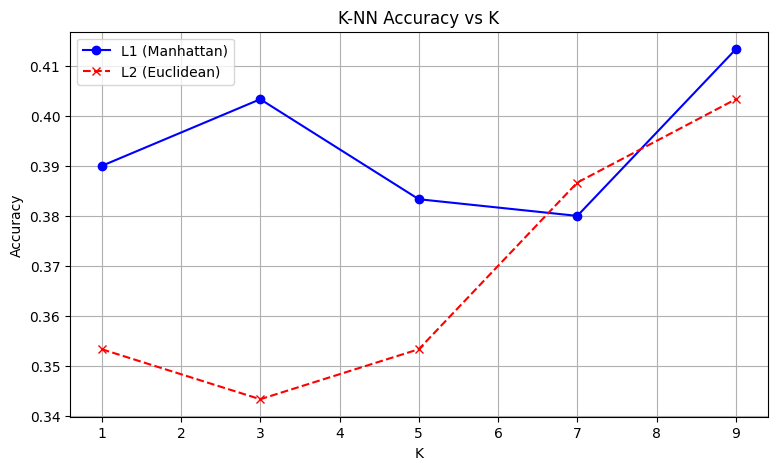

In [9]:
# Compute mean accuracy for each k
mean_l1 = [np.mean(l1_scores[k]) for k in k_list]
mean_l2 = [np.mean(l2_scores[k]) for k in k_list]

print("\nAverage Accuracy:")
print("K\tL1\tL2")
for i, k in enumerate(k_list):
    print(f"{k}\t{mean_l1[i]:.3f}\t{mean_l2[i]:.3f}")

# Plot
plt.figure(figsize=(9, 5))
plt.plot(k_list, mean_l1, marker='o', linestyle='-', color='blue', label='L1 (Manhattan)')
plt.plot(k_list, mean_l2, marker='x', linestyle='--', color='red', label='L2 (Euclidean)')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('K-NN Accuracy vs K')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
print("\nShowing 5 sample predictions from the validation set:")
print("-" * 40)

k_best = 9

for i in range(5):
    predicted = knn_predict(X_train, y_train, X_val[i], k_best, l1_dist)
    true = y_val[i]
    
    res = "CORRECT" if predicted == true else "WRONG"
    print(f"Image {i+1}: True: {classes[true]:<6} | Pred: {classes[predicted]:<6} -> {res}")


Showing 5 sample predictions from the validation set:
----------------------------------------
Image 1: True: panda  | Pred: panda  -> CORRECT
Image 2: True: cat    | Pred: cat    -> CORRECT
Image 3: True: dog    | Pred: cat    -> WRONG
Image 4: True: panda  | Pred: dog    -> WRONG
Image 5: True: cat    | Pred: cat    -> CORRECT
